In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

# load data
(genome_train, genome_test) = tfds.load('genomics_ood', split=['train[:1%]', 'test[:1%]'])

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/12 [00:00<?, ? file/s]


Dataset genomics_ood downloaded and prepared to /root/tensorflow_datasets/genomics_ood/0.0.1. Subsequent calls will reuse this data.


In [2]:
print(len(genome_train), len(genome_test))

10000 1000


In [3]:
encoding = 'utf-8'
sequences_tr = []
sequences_tr_label = []
i = 0
for seq in genome_train:
  sequences_tr.append(str(seq['seq'].numpy(), encoding))
  sequences_tr_label.append(str(seq['label'].numpy()))
  i = i+1
  if i==10000:
    break

print(set(sequences_tr_label))

{'6', '0', '3', '2', '7', '1', '4', '8', '9', '5'}


In [4]:
# encoding the sequences
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
integer_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(categories='auto')
seq_tr_encoded = []

for seq in sequences_tr:
    integer_encoded = np.array(integer_encoder.fit_transform(list(seq))).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    seq_tr_encoded.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
seq_tr_encoded = np.stack(seq_tr_encoded)
print(sequences_tr[0])
print(seq_tr_encoded[0][:10])

AAACTATGTTATATTCACGATGATTAACTTACAAAGGAGTTTCAACTATGAAGATGATAAACAAATTAATCGTTCCGGTAACAGCTAGTGCTTTATTATTAGGCGCTTGTGGCGCTAGTGCCACAGACTCTAAAGAAAATACATTAATTTCTTCTAAAGCTGGAGACGTAACAGTTGCAGATACAATGAAAAAAATCGGTAAAGATCAAATTGCAAATGCATCATTTACTGAAATGTTAAATAAAATTTT
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [5]:
# encode the label
one_hot_encoder = OneHotEncoder(categories='auto')
sequences_train_label = np.array(sequences_tr_label).reshape(-1, 1)
seq_tr_label_encoded = one_hot_encoder.fit_transform(sequences_train_label).toarray()

print(sequences_train_label)
print(seq_tr_label_encoded[:10])

[['7']
 ['5']
 ['1']
 ...
 ['9']
 ['1']
 ['2']]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
# split data set
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(seq_tr_encoded, seq_tr_label_encoded, test_size=0.25, random_state=2021)

In [7]:
# CNN model
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

cnnModel = Sequential()
cnnModel.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(seq_tr_encoded.shape[1], 4)))
cnnModel.add(Conv1D(filters=16, kernel_size=16))
cnnModel.add(MaxPooling1D(pool_size=4))
cnnModel.add(Flatten())
cnnModel.add(Dense(16, activation='relu'))
cnnModel.add(Dense(10, activation='softmax'))

cnnModel.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])
cnnModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 239, 32)           1568      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 224, 16)           8208      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 56, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                14352     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 24,298
Trainable params: 24,298
Non-trainable params: 0
____________________________________________________

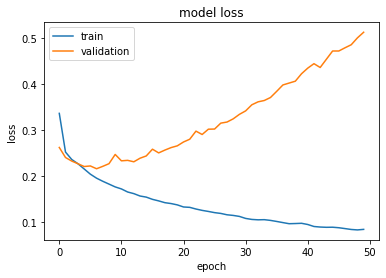

In [8]:
hist = cnnModel.fit(seq_tr_encoded, seq_tr_label_encoded, epochs=50, verbose=0, validation_split=0.25)

plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [14]:
# prepare the test sequences
sequences_test = []
sequences_test_label = []
i = 0
for seq in genome_test:
  sequences_test.append(str(seq['seq'].numpy(), encoding))
  sequences_test_label.append(str(seq['label'].numpy()))
  i = i+1
  if i==2:
    break

seq_test_encoded = []
for seq in sequences_test:
    integer_encoded = np.array(integer_encoder.fit_transform(list(seq))).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    seq_test_encoded.append(one_hot_encoded.toarray())

seq_test_encoded = np.stack(seq_test_encoded)


In [19]:
# predict test sequences
pred_y = cnnModel.predict(seq_test_encoded)
print(np.argmax(pred_y[0]), np.argmax(pred_y[1]))

1 8


In [11]:
# the real labels
print(sequences_test_label)

['1', '8']


In [21]:
# change 2 letters in the sequences
seq_test_encoded[0][100], seq_test_encoded[0][200] = [0., 0., 0., 0.],  [0., 0., 0., 0.]
seq_test_encoded[1][100], seq_test_encoded[1][200] = [0., 0., 0., 0.],  [0., 0., 0., 0.]

In [22]:
# predict again
pred_y = cnnModel.predict(seq_test_encoded)
print(np.argmax(pred_y[0]), np.argmax(pred_y[1]))

1 8


In [ ]:
# FCN model
from tensorflow.keras.layers import Dropout
seq_tr_encoded = seq_tr_encoded.reshape(-1, 1000)
fcnModel = Sequential()
fcnModel.add(Dense(512, input_shape=(1000,), activation='relu'))
fcnModel.add(Dense(512, activation='relu'))
fcnModel.add(Dropout(0.2))
fcnModel.add(Dense(10, activation='softmax'))
fcnModel.summary()

In [37]:
# train FCN model
fcnModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
fcnModel.fit(seq_tr_encoded, seq_tr_label_encoded, batch_size=128, epochs=10, verbose=1)

Epoch 1/10
79/79 [==============================] - 2s 17ms/step - loss: 0.0165 - accuracy: 0.9975
Epoch 2/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0470 - accuracy: 0.9867
Epoch 3/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0551 - accuracy: 0.9825
Epoch 4/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0299 - accuracy: 0.9908
Epoch 5/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0449 - accuracy: 0.9862
Epoch 6/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0167 - accuracy: 0.9955
Epoch 7/10
79/79 [==============================] - 1s 17ms/step - loss: 0.0082 - accuracy: 0.9979
Epoch 8/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0090 - accuracy: 0.9974
Epoch 9/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0099 - accuracy: 0.9967
Epoch 10/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0176 - accuracy: 0.9944


In [41]:
# predict test sequences
seq_test_encoded = seq_test_encoded.reshape(-1, 1000)
pred_y = fcnModel.predict(seq_test_encoded)
print(np.argmax(pred_y[0]), np.argmax(pred_y[1]))

4 2
